# Analytics

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- 18/0013637 Arthur Paiva Tavares
- 17/0031538 Dâmaso Júnio pereira Brasileo
- 18/0063723 Fellipe dos Santos Araujo
- 15/0135939 Letícia Karla Araújo
- 20/0057227 Caio Vitor de Oliveira
- 20/0036351 Clara Marcelino de Sousa
- 20/0030469 Felipe Candido de Moura
- 19/0091720 Lucas macedo Barboza
- 20/0023411 Luíza Esteves dos Santos
- 20/0041959 Maurício Machado Filho
- 19/0037806 Samuel Furtado Avila

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here
print(len(jsons))

25


In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-Eu-Pescador-(.*?)-(.*?)-(.*?)-(.*?)-(.*?):(.*?):(.*?)-v(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[8]

    df['date'] = aux_df[2] + '-' + aux_df[3] + '-' + aux_df[4] + '-' + aux_df[5] + ':' + aux_df[6] + ':' + aux_df[7]

    # print(aux_df)
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version,date
180,duplicated_lines_density,0.0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
181,functions,20,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
182,test_execution_time,122,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
183,test_failures,0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
184,test_errors,0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
185,security_rating,1.0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
186,tests,23,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
187,files,8,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
188,complexity,46,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
189,ncloc,384,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)
        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours. 
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-Eu-Pescador-(.*?)-(.*?)-(.*?)-(.*?)-(.*?):(.*?):(.*?)-v(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[8]

    df['date'] = aux_df[2] + '-' + aux_df[3] + '-' + aux_df[4] + '-' + aux_df[5] + ':' + aux_df[6] + ':' + aux_df[7]

    # print(aux_df)
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

array(['FishLog', 'FishWiki', 'User', 'UserInterface'], dtype=object)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,tests,test_errors,test_failures,test_execution_time,security_rating,filename,repository,version,date
590,src/app.ts,0,0,0.0,0.0,0.0,11,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
591,src/middleware/auth.ts,3,5,0.0,0.0,38.9,31,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
592,src/config/database.ts,2,4,0.0,0.0,0.0,27,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
593,src/models/fishLog.ts,0,0,0.0,0.0,100.0,94,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
594,src/controllers/fishLogController.ts,8,29,0.0,0.0,84.7,186,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
595,src/routes/fishLogRoutes.ts,6,6,0.0,0.0,0.0,25,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
596,src/routes/router.ts,0,0,16.7,0.0,0.0,5,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
597,src/server.ts,1,2,0.0,0.0,0.0,5,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,2.1.1,03-18-2022-15:28:02
8,src/app.ts,0,0,0.0,0.0,0.0,11,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-04-12-2...,FishLog,2.2.0,04-12-2022-11:21:33
9,src/middleware/auth.ts,3,5,0.0,0.0,38.9,31,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-04-12-2...,FishLog,2.2.0,04-12-2022-11:21:33


#### Create dataframe per repository

In [12]:
repo1_df = file_component_df[file_component_df['repository'] == 'UserInterface']
repo2_df = file_component_df[file_component_df['repository'] == 'User']
repo3_df = file_component_df[file_component_df['repository'] == 'FishWiki']
repo4_df = file_component_df[file_component_df['repository'] == 'FishLog']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [14]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [ ]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [ ]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [17]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [18]:
def create_metrics_df(df):
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    date_list = []
    
    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        date_list.append(version_df['date'].iloc[0])
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm6': m6_list,
                               'LOC': ncloc_list,
                               'Repository': repository_list, 
                               'Version': version_list,
                               'Date': date_list
                            })
        
    return metrics_df

In [19]:
repo1_metrics = create_metrics_df(repo1_df)
repo2_metrics = create_metrics_df(repo2_df)
repo3_metrics = create_metrics_df(repo3_df)
repo4_metrics = create_metrics_df(repo4_df)

### Data visualization

- You must do this for each of your repositories

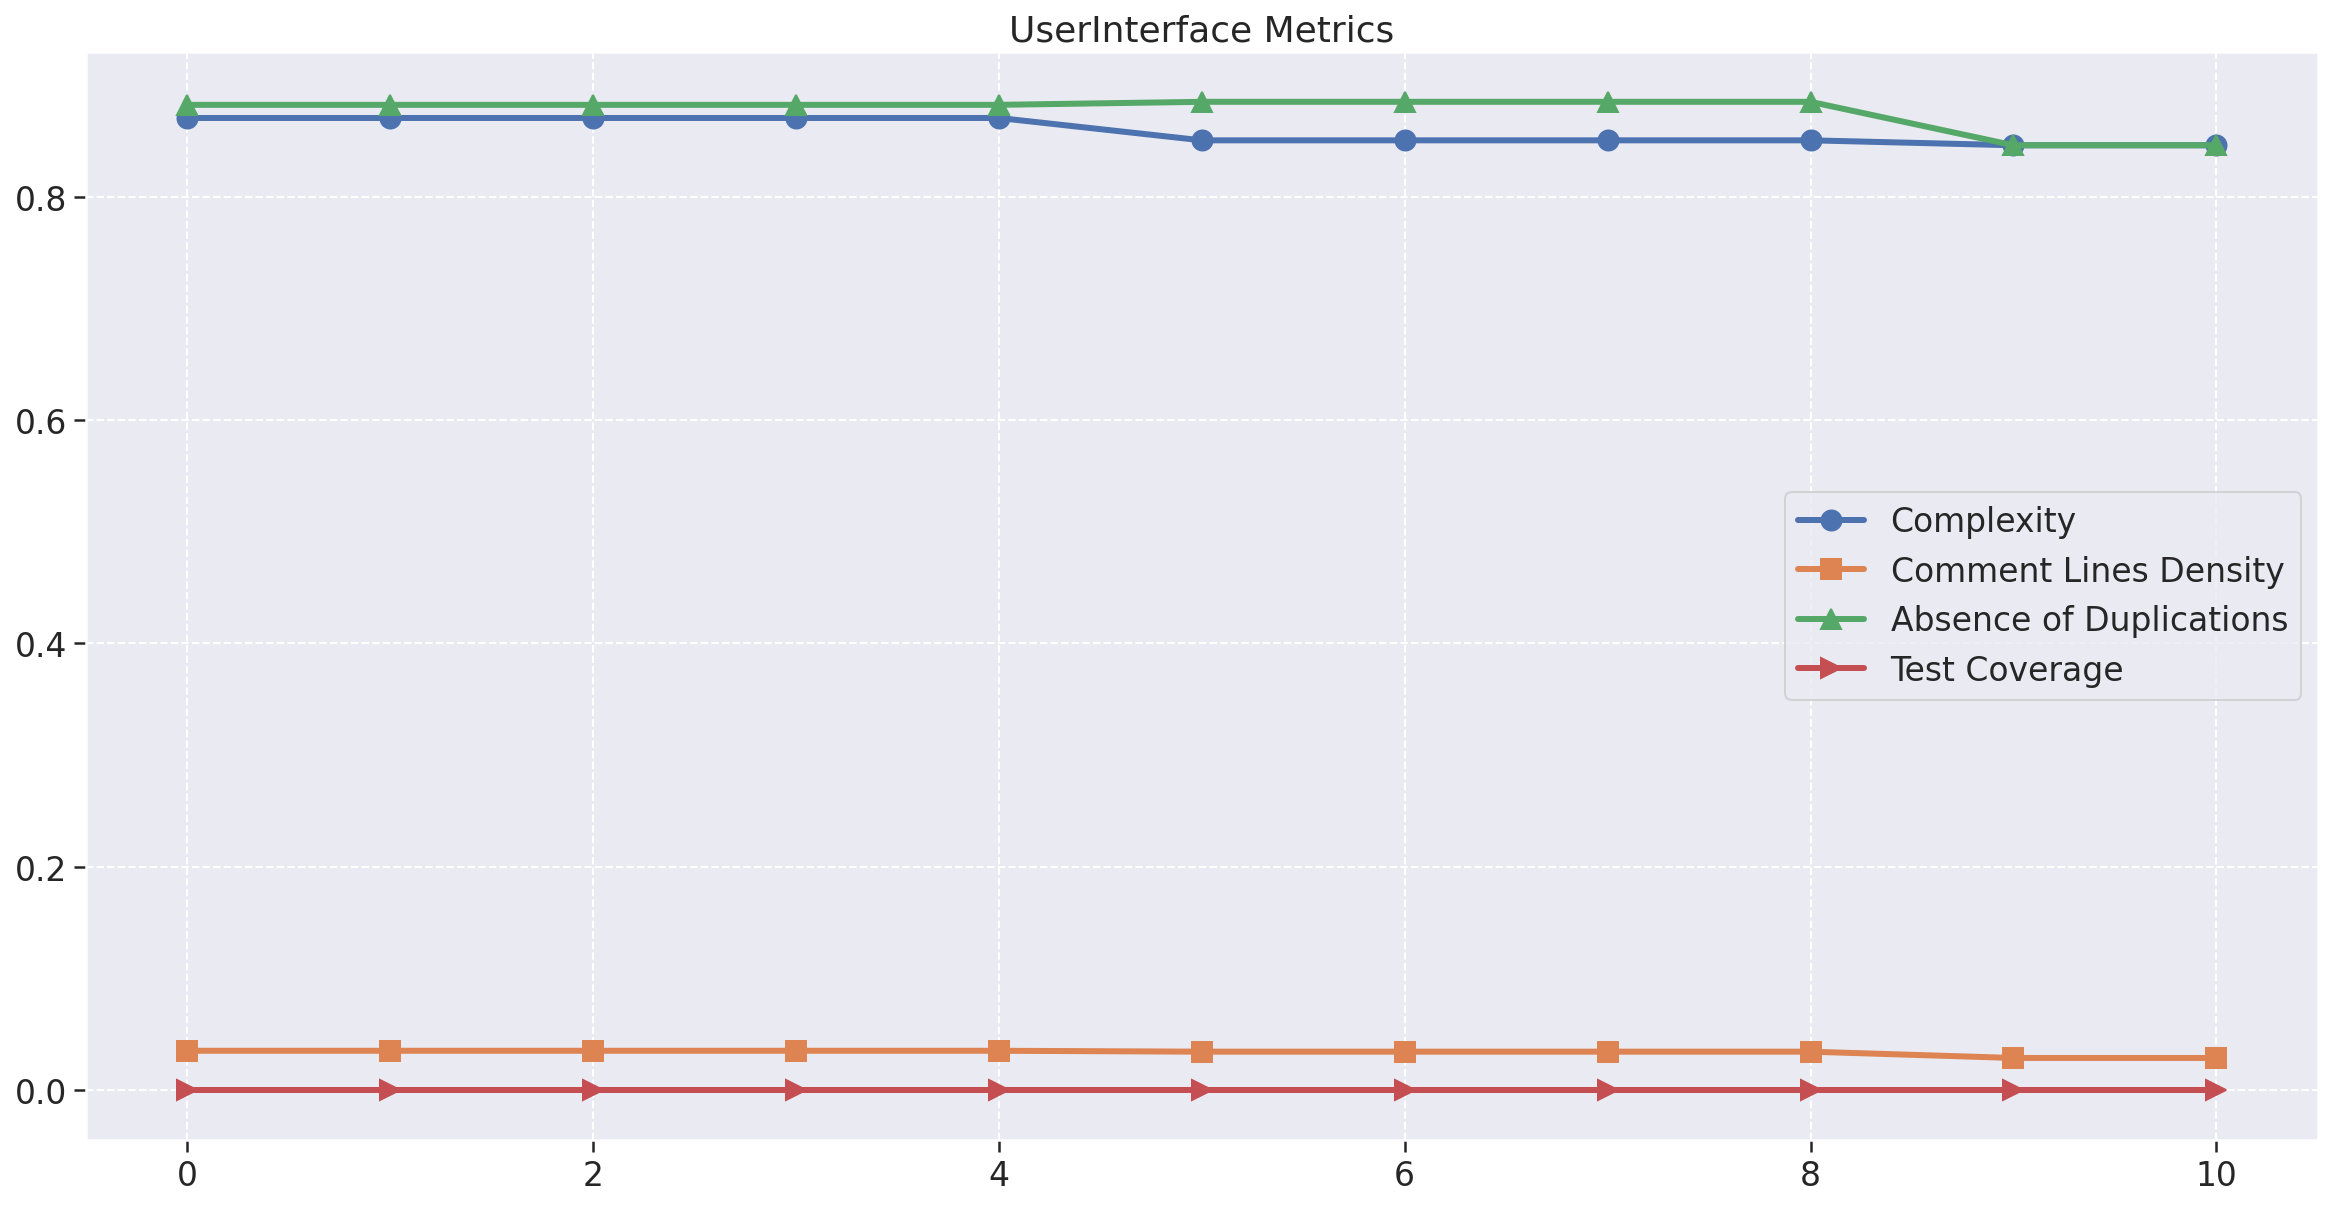

In [20]:
fig = plt.figure(figsize=(20, 10))

plt.title('UserInterface Metrics')
plt.plot(repo1_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo1_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo1_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo1_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

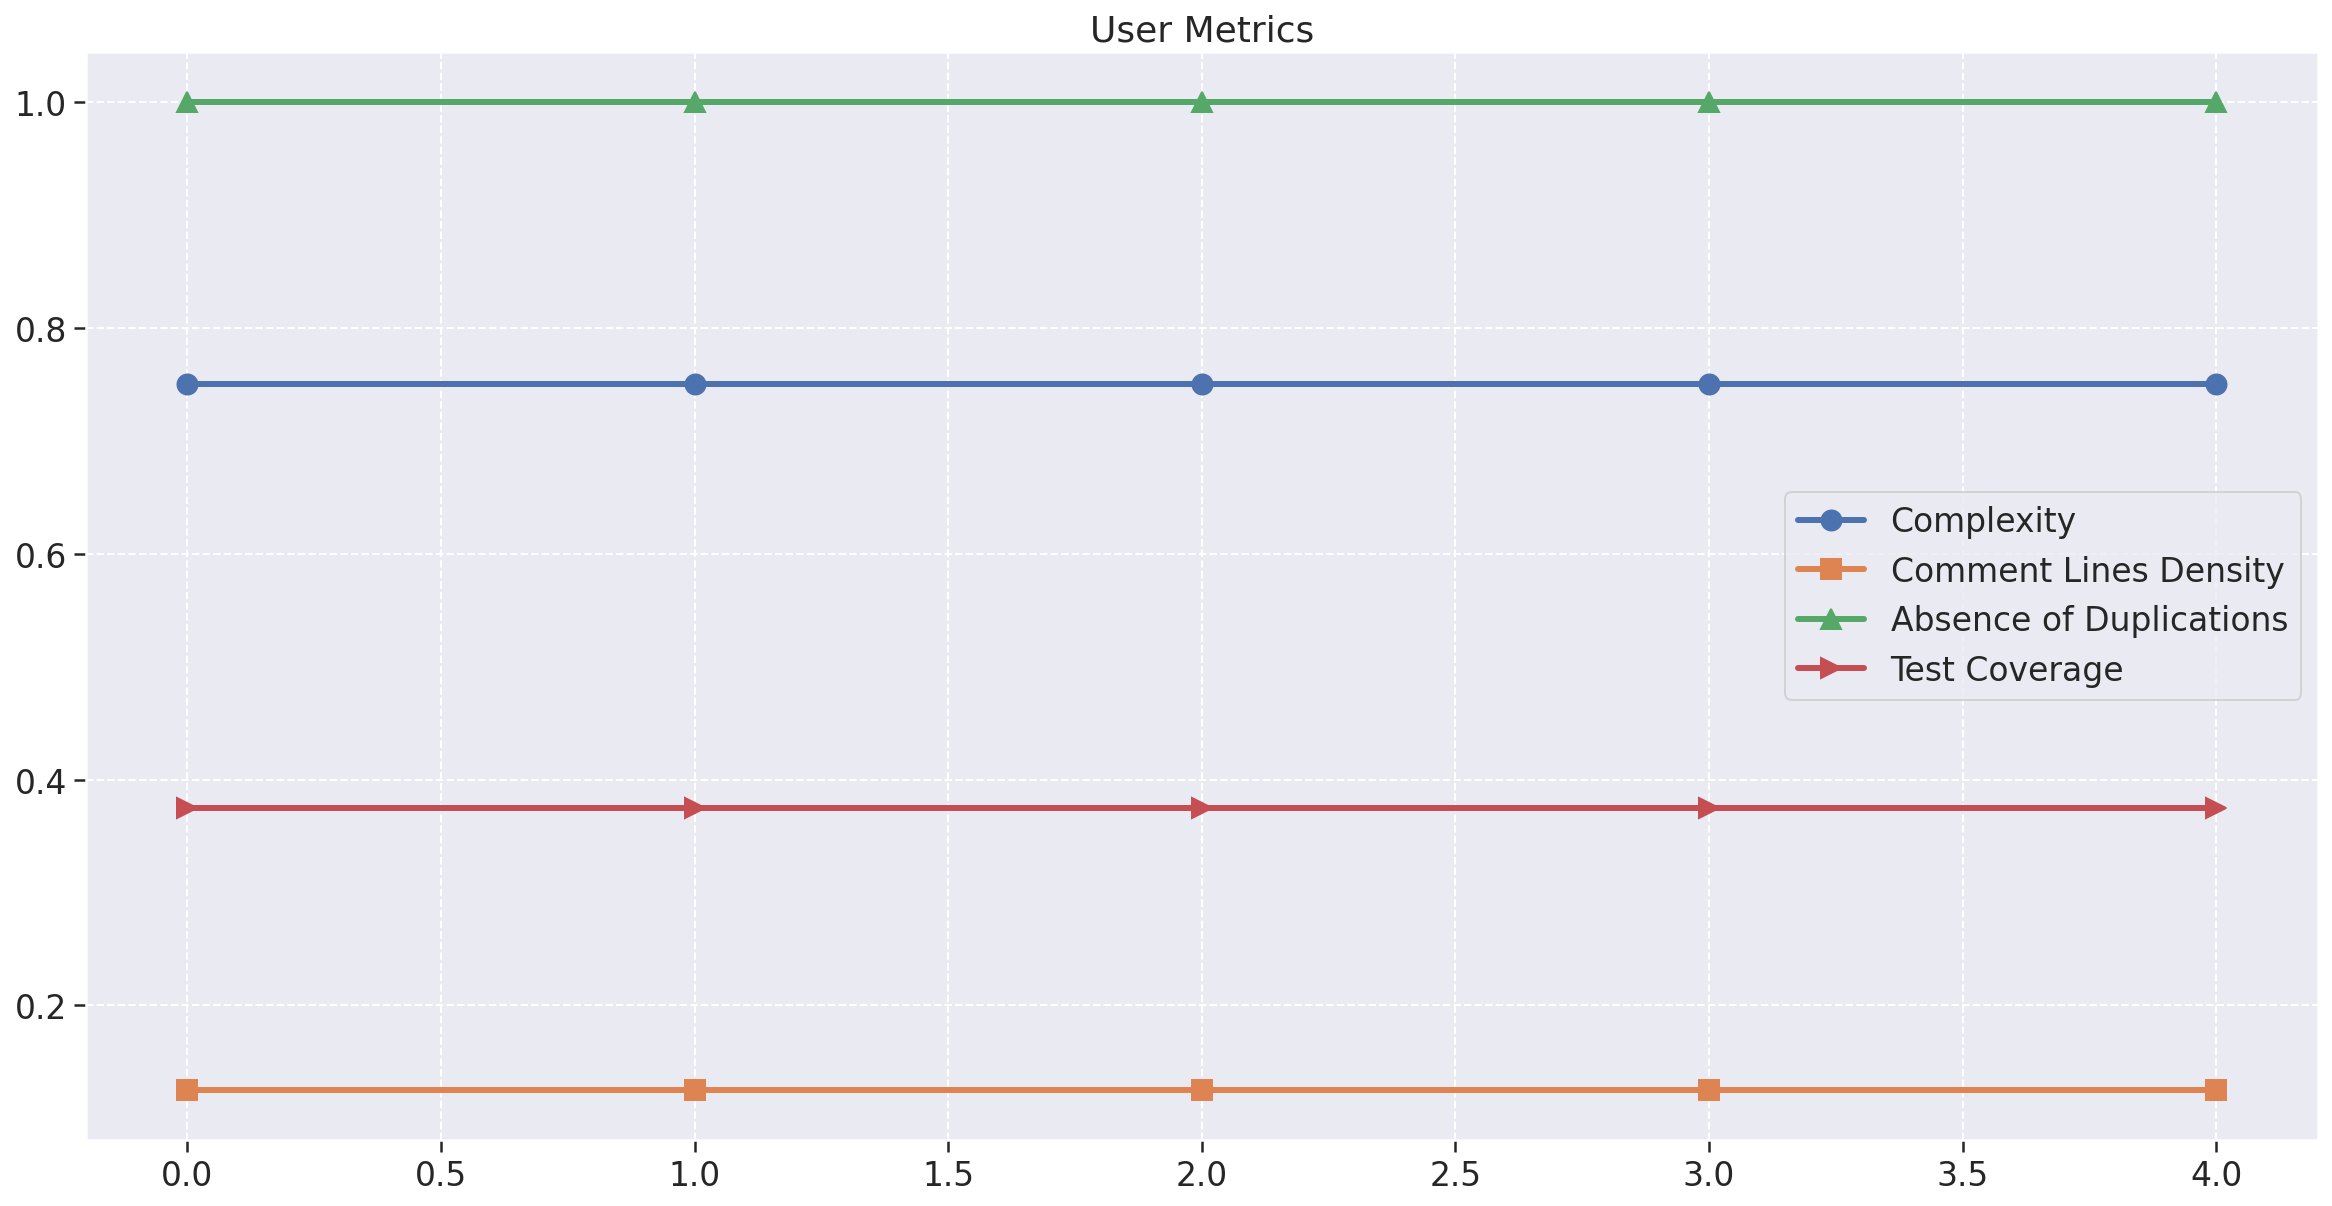

In [21]:
fig = plt.figure(figsize=(20, 10))

plt.title('User Metrics')
plt.plot(repo2_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo2_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo2_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo2_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

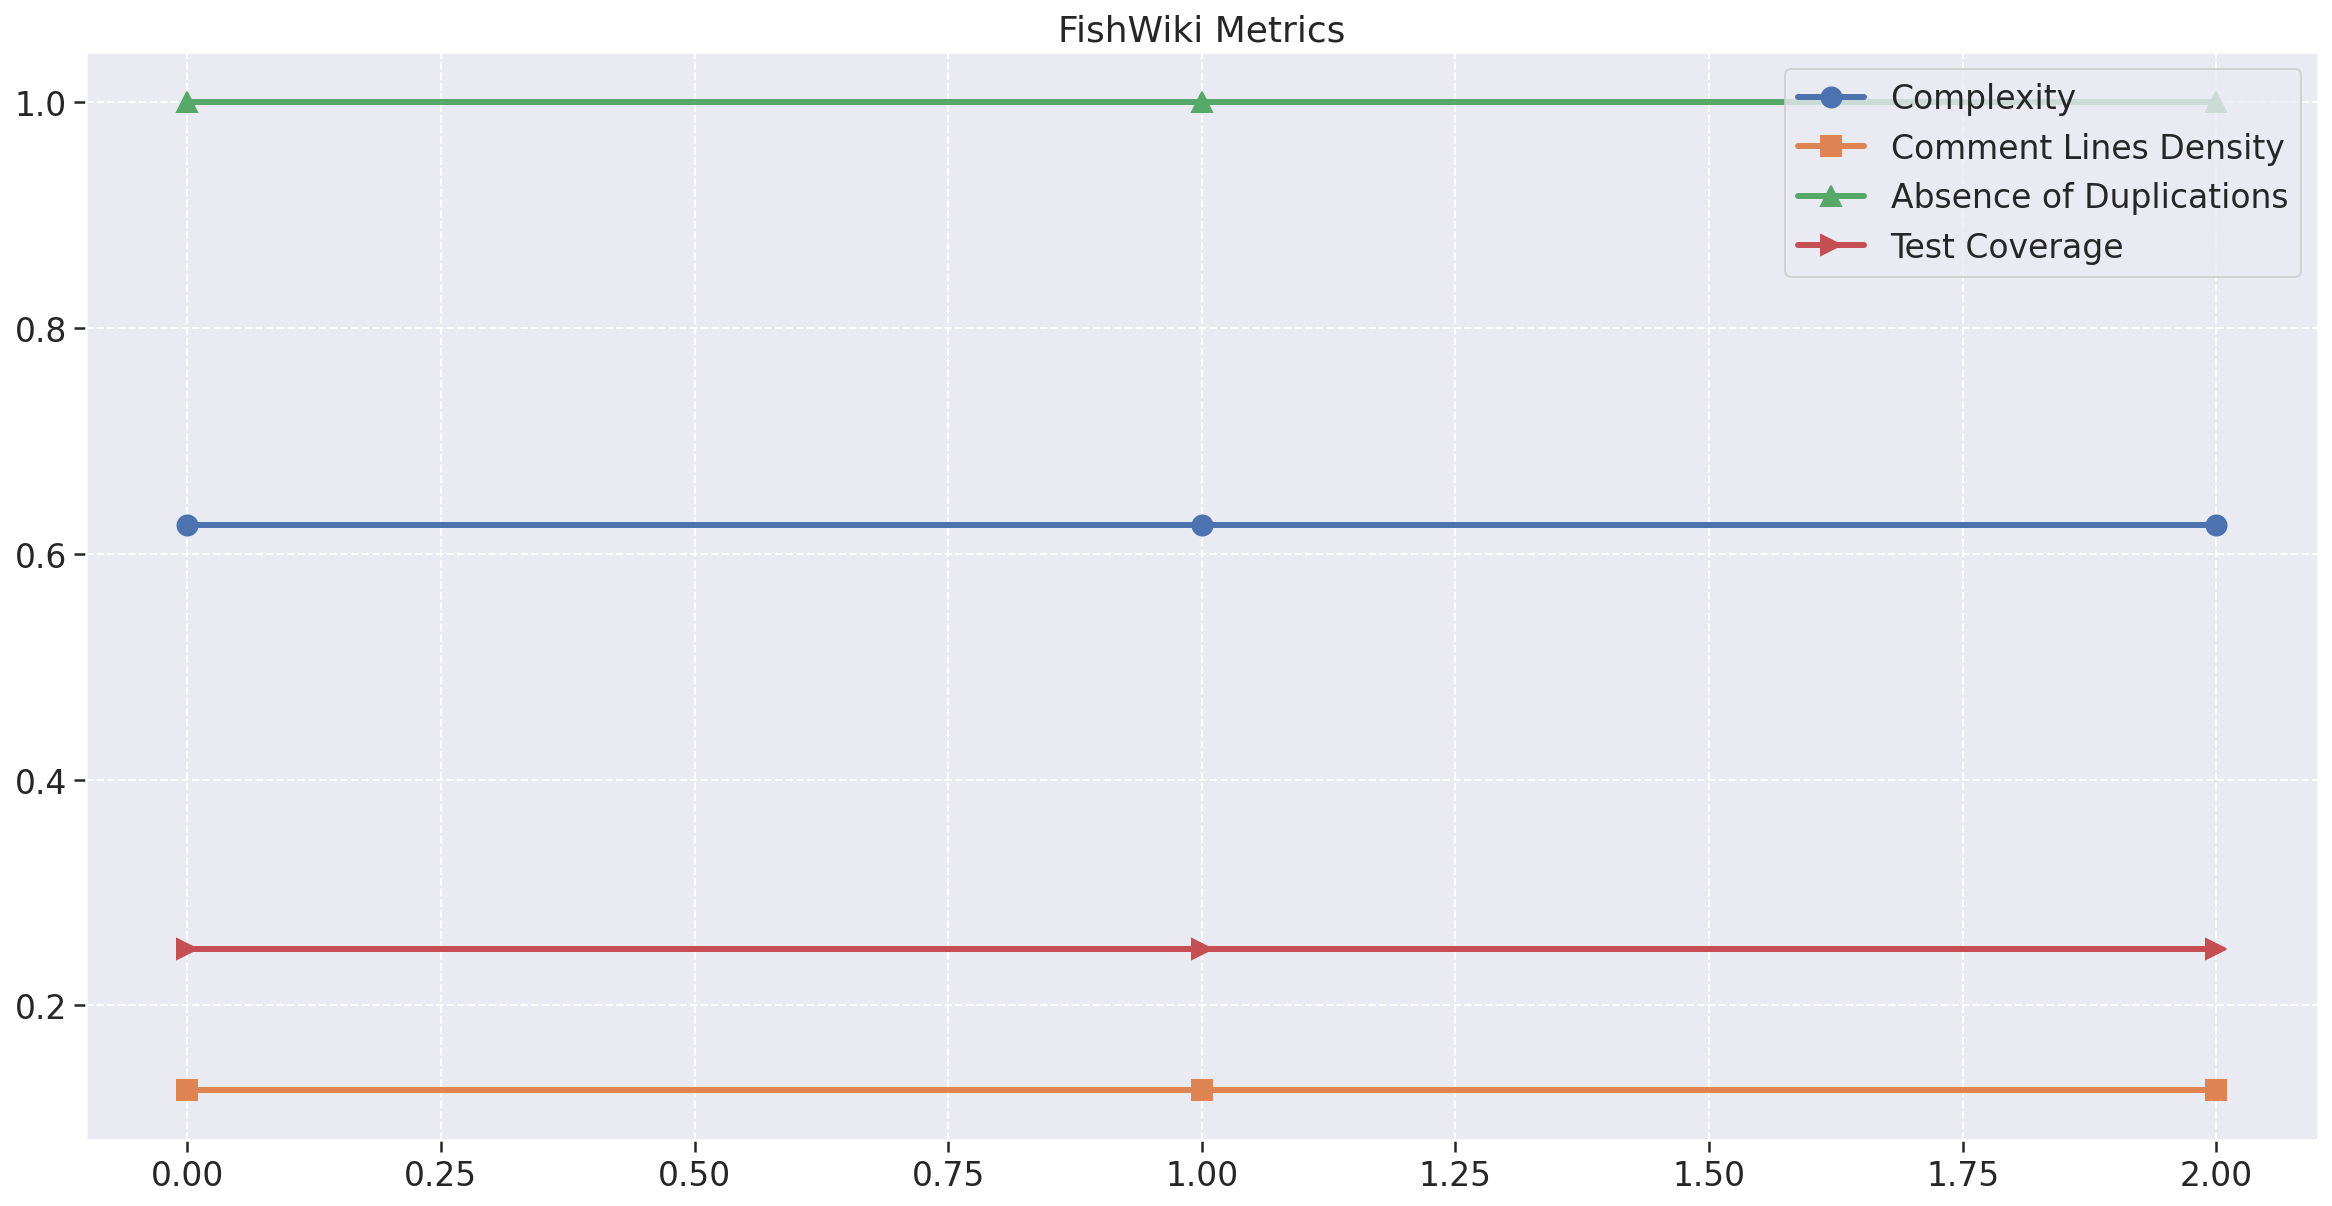

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishWiki Metrics')
plt.plot(repo3_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo3_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo3_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo3_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

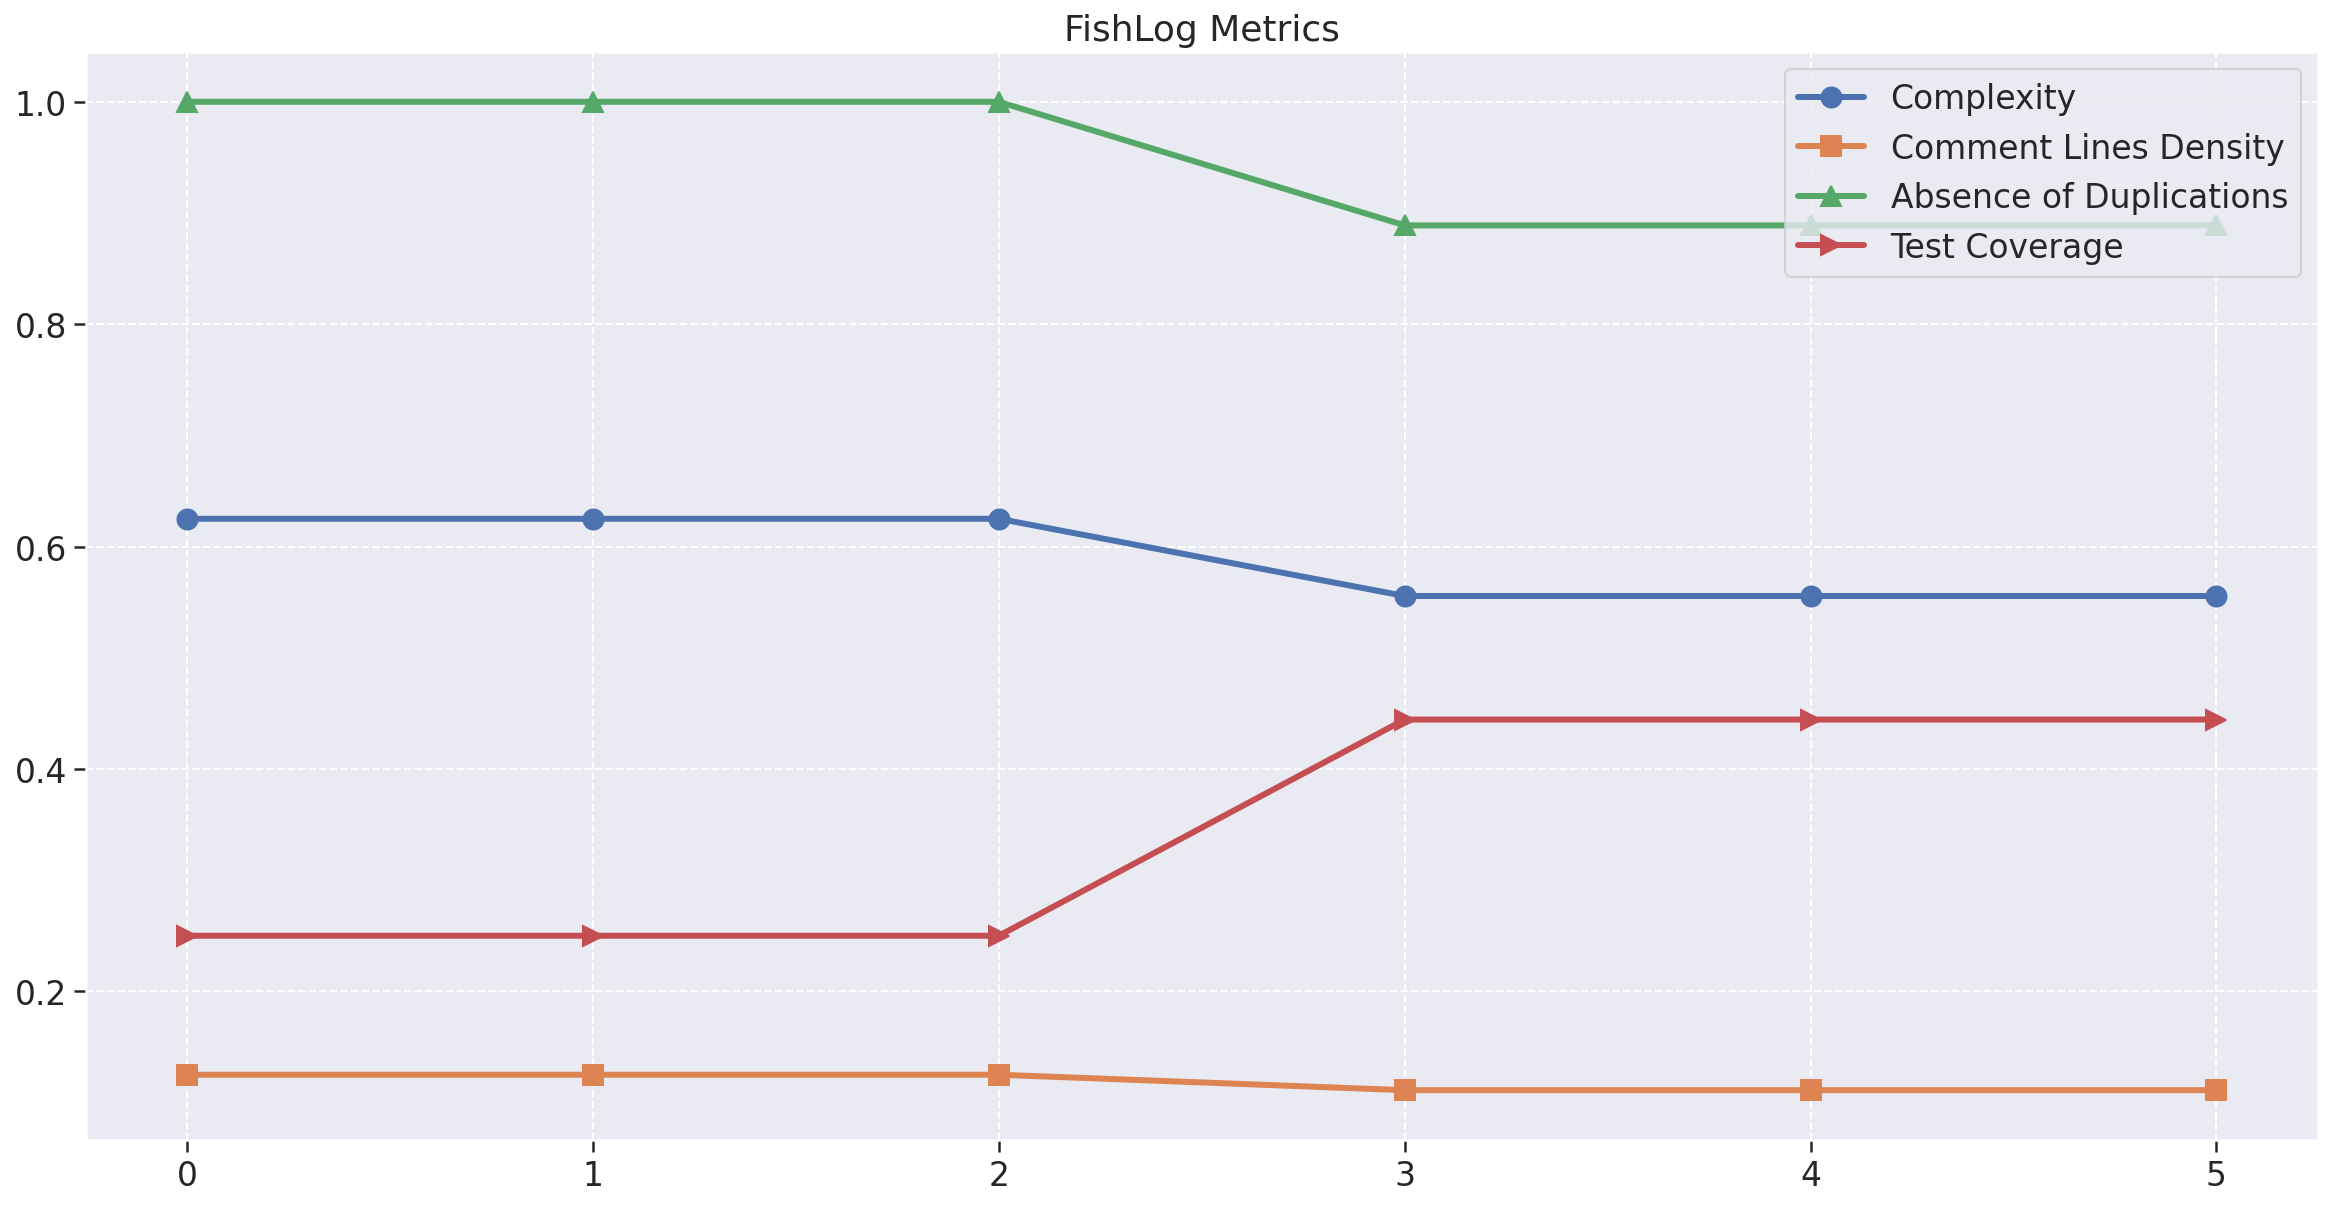

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishLog Metrics')
plt.plot(repo4_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo4_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo4_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo4_metrics['m6'], linewidth=3, marker='>', label='Test Coverage', markersize=10)
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [24]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

repo1_metrics['code_quality'] = ((repo1_metrics['m1']*pm1) + (repo1_metrics['m2']*pm2) + (repo1_metrics['m3']*pm3)) * psc1
repo2_metrics['code_quality'] = ((repo2_metrics['m1']*pm1) + (repo2_metrics['m2']*pm2) + (repo2_metrics['m3']*pm3)) * psc1
repo3_metrics['code_quality'] = ((repo3_metrics['m1']*pm1) + (repo3_metrics['m2']*pm2) + (repo3_metrics['m3']*pm3)) * psc1
repo4_metrics['code_quality'] = ((repo4_metrics['m1']*pm1) + (repo4_metrics['m2']*pm2) + (repo4_metrics['m3']*pm3)) * psc1

repo1_metrics['testing_status'] = repo1_metrics['m6'] * psc2
repo2_metrics['testing_status'] = repo2_metrics['m6'] * psc2
repo3_metrics['testing_status'] = repo3_metrics['m6'] * psc2
repo4_metrics['testing_status'] = repo4_metrics['m6'] * psc2


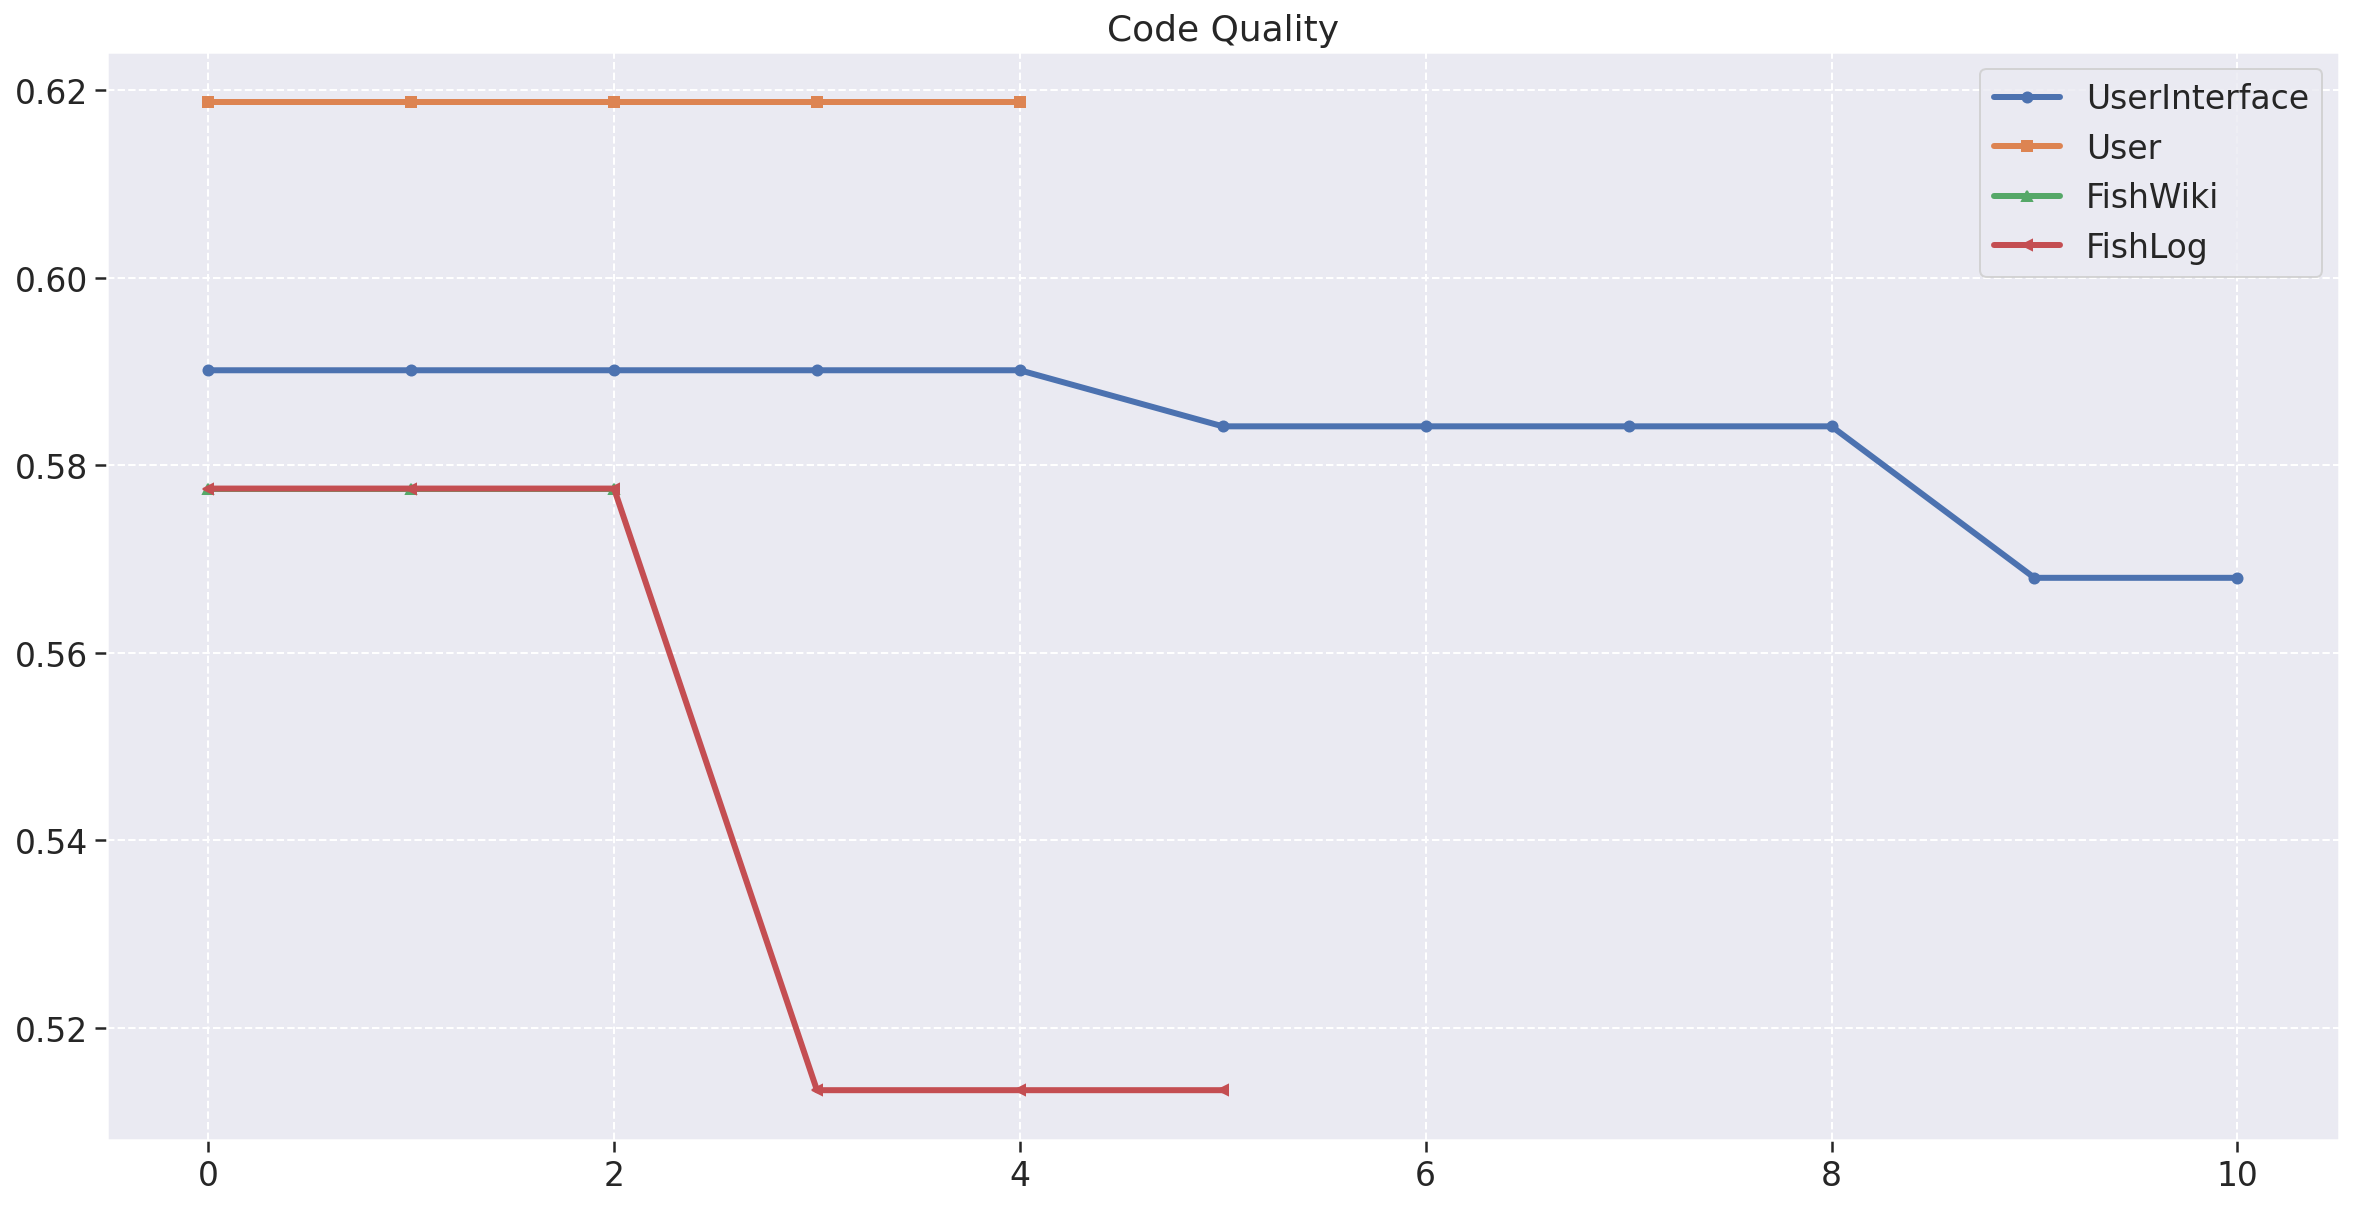

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('Code Quality')
plt.plot(repo1_metrics['code_quality'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['code_quality'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['code_quality'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['code_quality'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

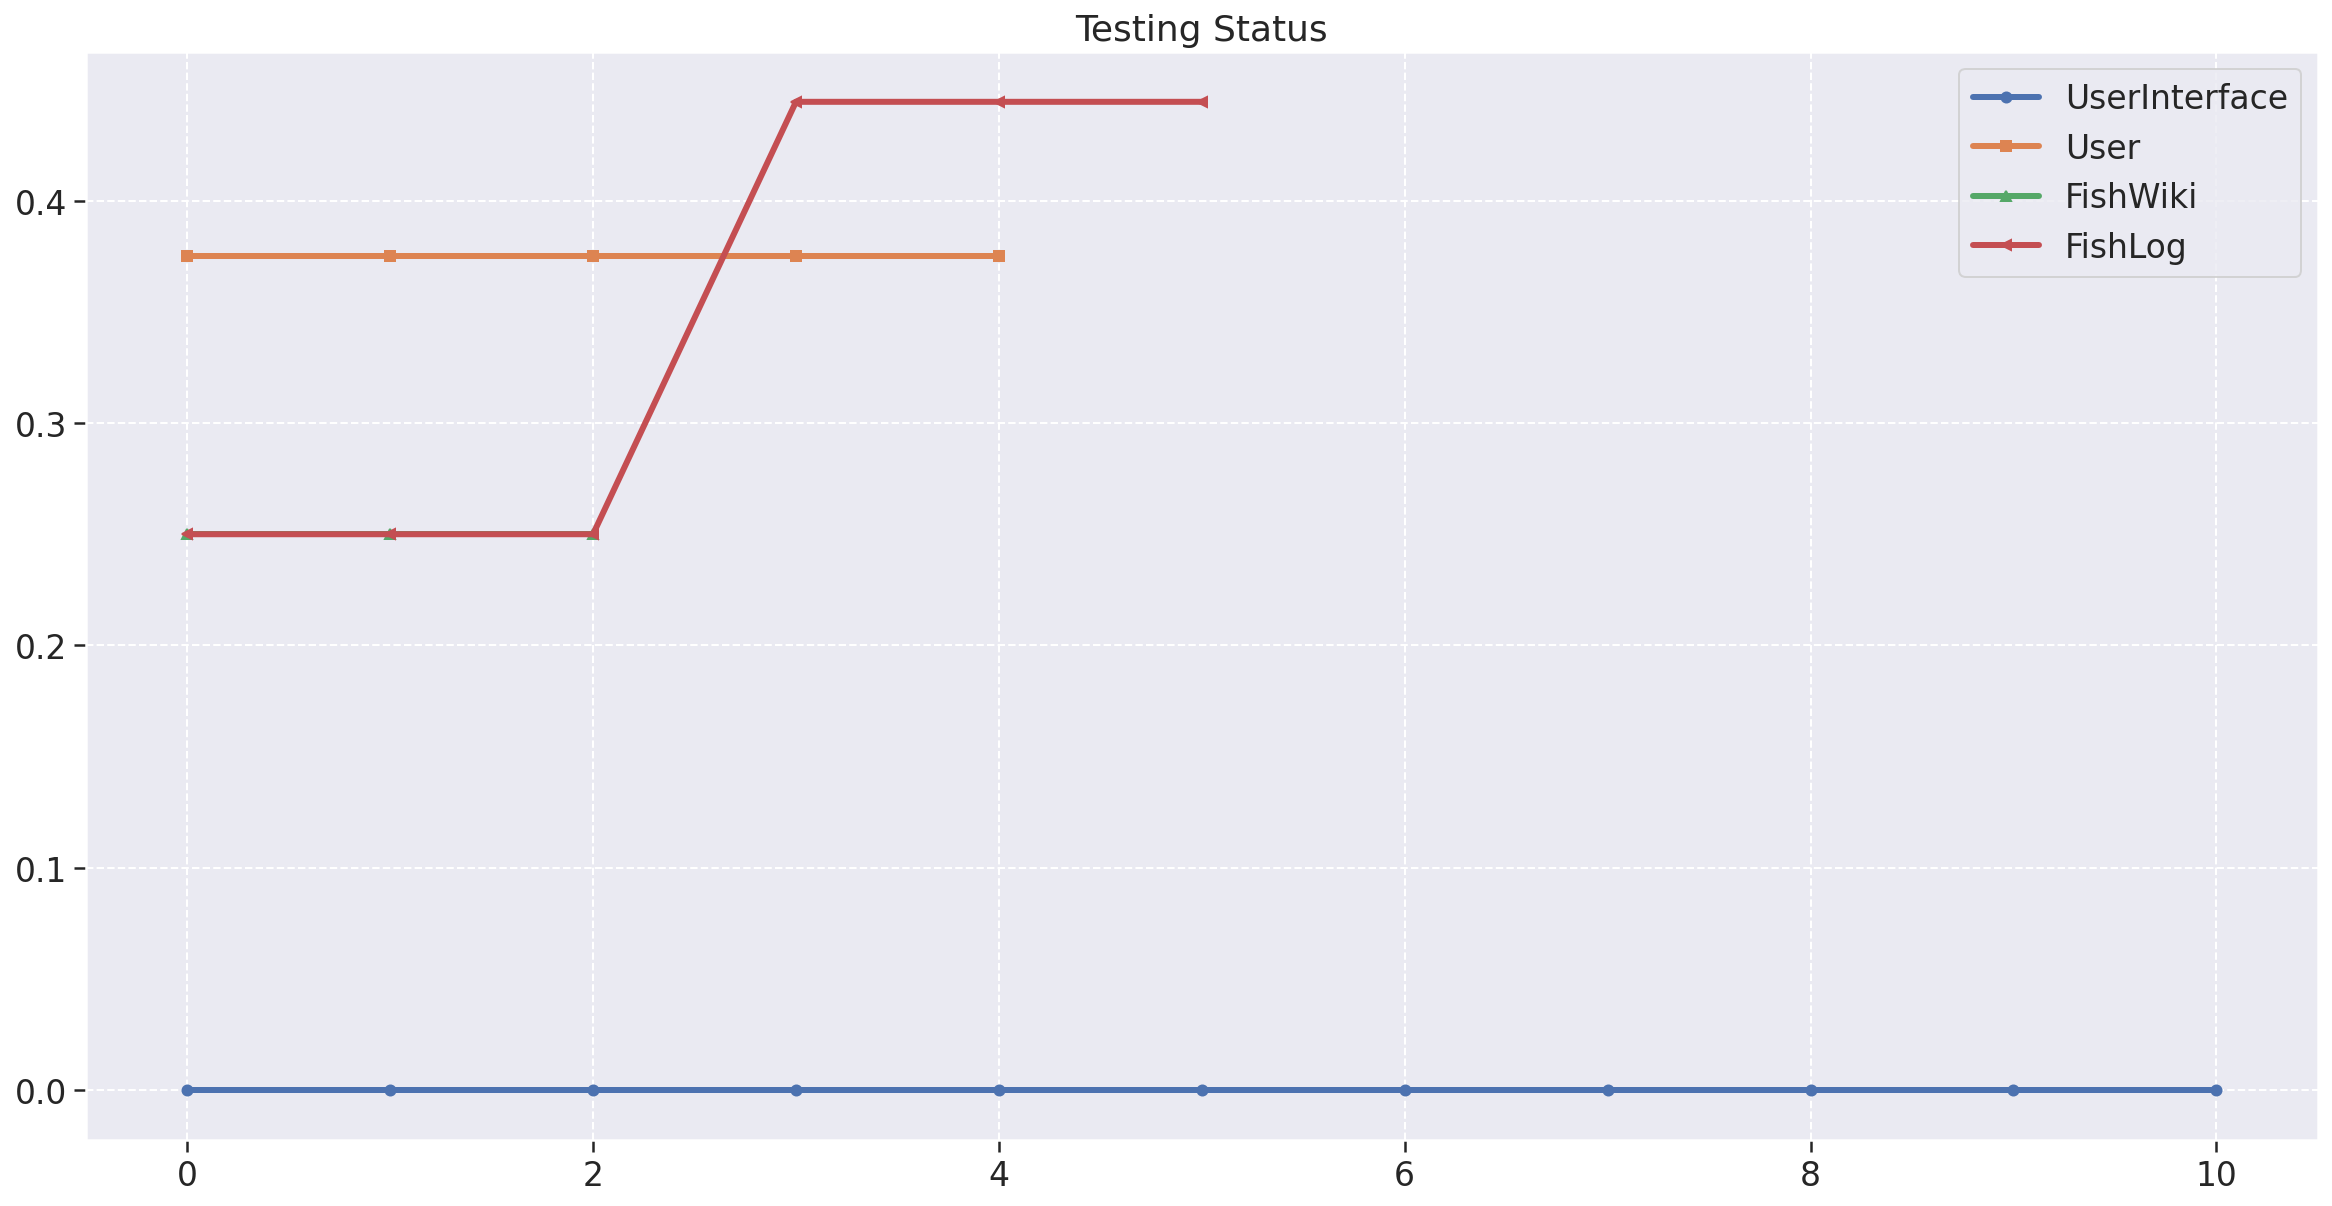

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(repo1_metrics['testing_status'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['testing_status'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['testing_status'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['testing_status'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

In [30]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, repo3_metrics, repo4_metrics], ignore_index=True)

metrics_df['Maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['Total_QR'] = metrics_df['Maintainability'] + metrics_df['Reliability']

In [31]:
metrics_df

,m1,m2,m3,m6,LOC,Repository,Version,Date,code_quality,testing_status,Maintainability,Reliability,Total_QR
0,0.870588,0.035294,0.882353,0.000000,5458,UserInterface,1.1.3,03-18-2022-15:08:02,0.590118,0.000000,0.295059,0.000000,0.295059
1,0.870588,0.035294,0.882353,0.000000,5497,UserInterface,1.2.0,04-04-2022-14:41:40,0.590118,0.000000,0.295059,0.000000,0.295059
2,0.870588,0.035294,0.882353,0.000000,5497,UserInterface,1.3.0,04-06-2022-21:16:15,0.590118,0.000000,0.295059,0.000000,0.295059
3,0.870588,0.035294,0.882353,0.000000,5497,UserInterface,1.3.1,04-12-2022-11:28:43,0.590118,0.000000,0.295059,0.000000,0.295059
4,0.870588,0.035294,0.882353,0.000000,5497,UserInterface,1.4.0,04-12-2022-20:07:26,0.590118,0.000000,0.295059,0.000000,0.295059
5,0.850575,0.034483,0.885057,0.000000,5730,UserInterface,1.4.1,04-18-2022-21:42:35,0.584138,0.000000,0.292069,0.000000,0.292069
6,0.850575,0.034483,0.885057,0.000000,5730,UserInterface,1.4.2,04-19-2022-11:19:36,0.584138,0.000000,0.292069,0.000000,0.292069
7,0.850575,0.034483,0.885057,0.000000,5730,UserInterface,1.5.0,04-28-2022-18:59:26,0.584138,0.000000,0.292069,0.000000,0.292069
8,0.850575,0.034483,0.885057,0.000000,5730,UserInterface,2.0.0,04-29-2022-19:47:46,0.584138,0.000000,0.292069,0.000000,0.292069
9,0.846154,0.028846,0.846154,0.000000,6890,UserInterface,2.0.1,04-30-2022-00:03:23,0.567981,0.000000,0.283990,0.000000,0.283990


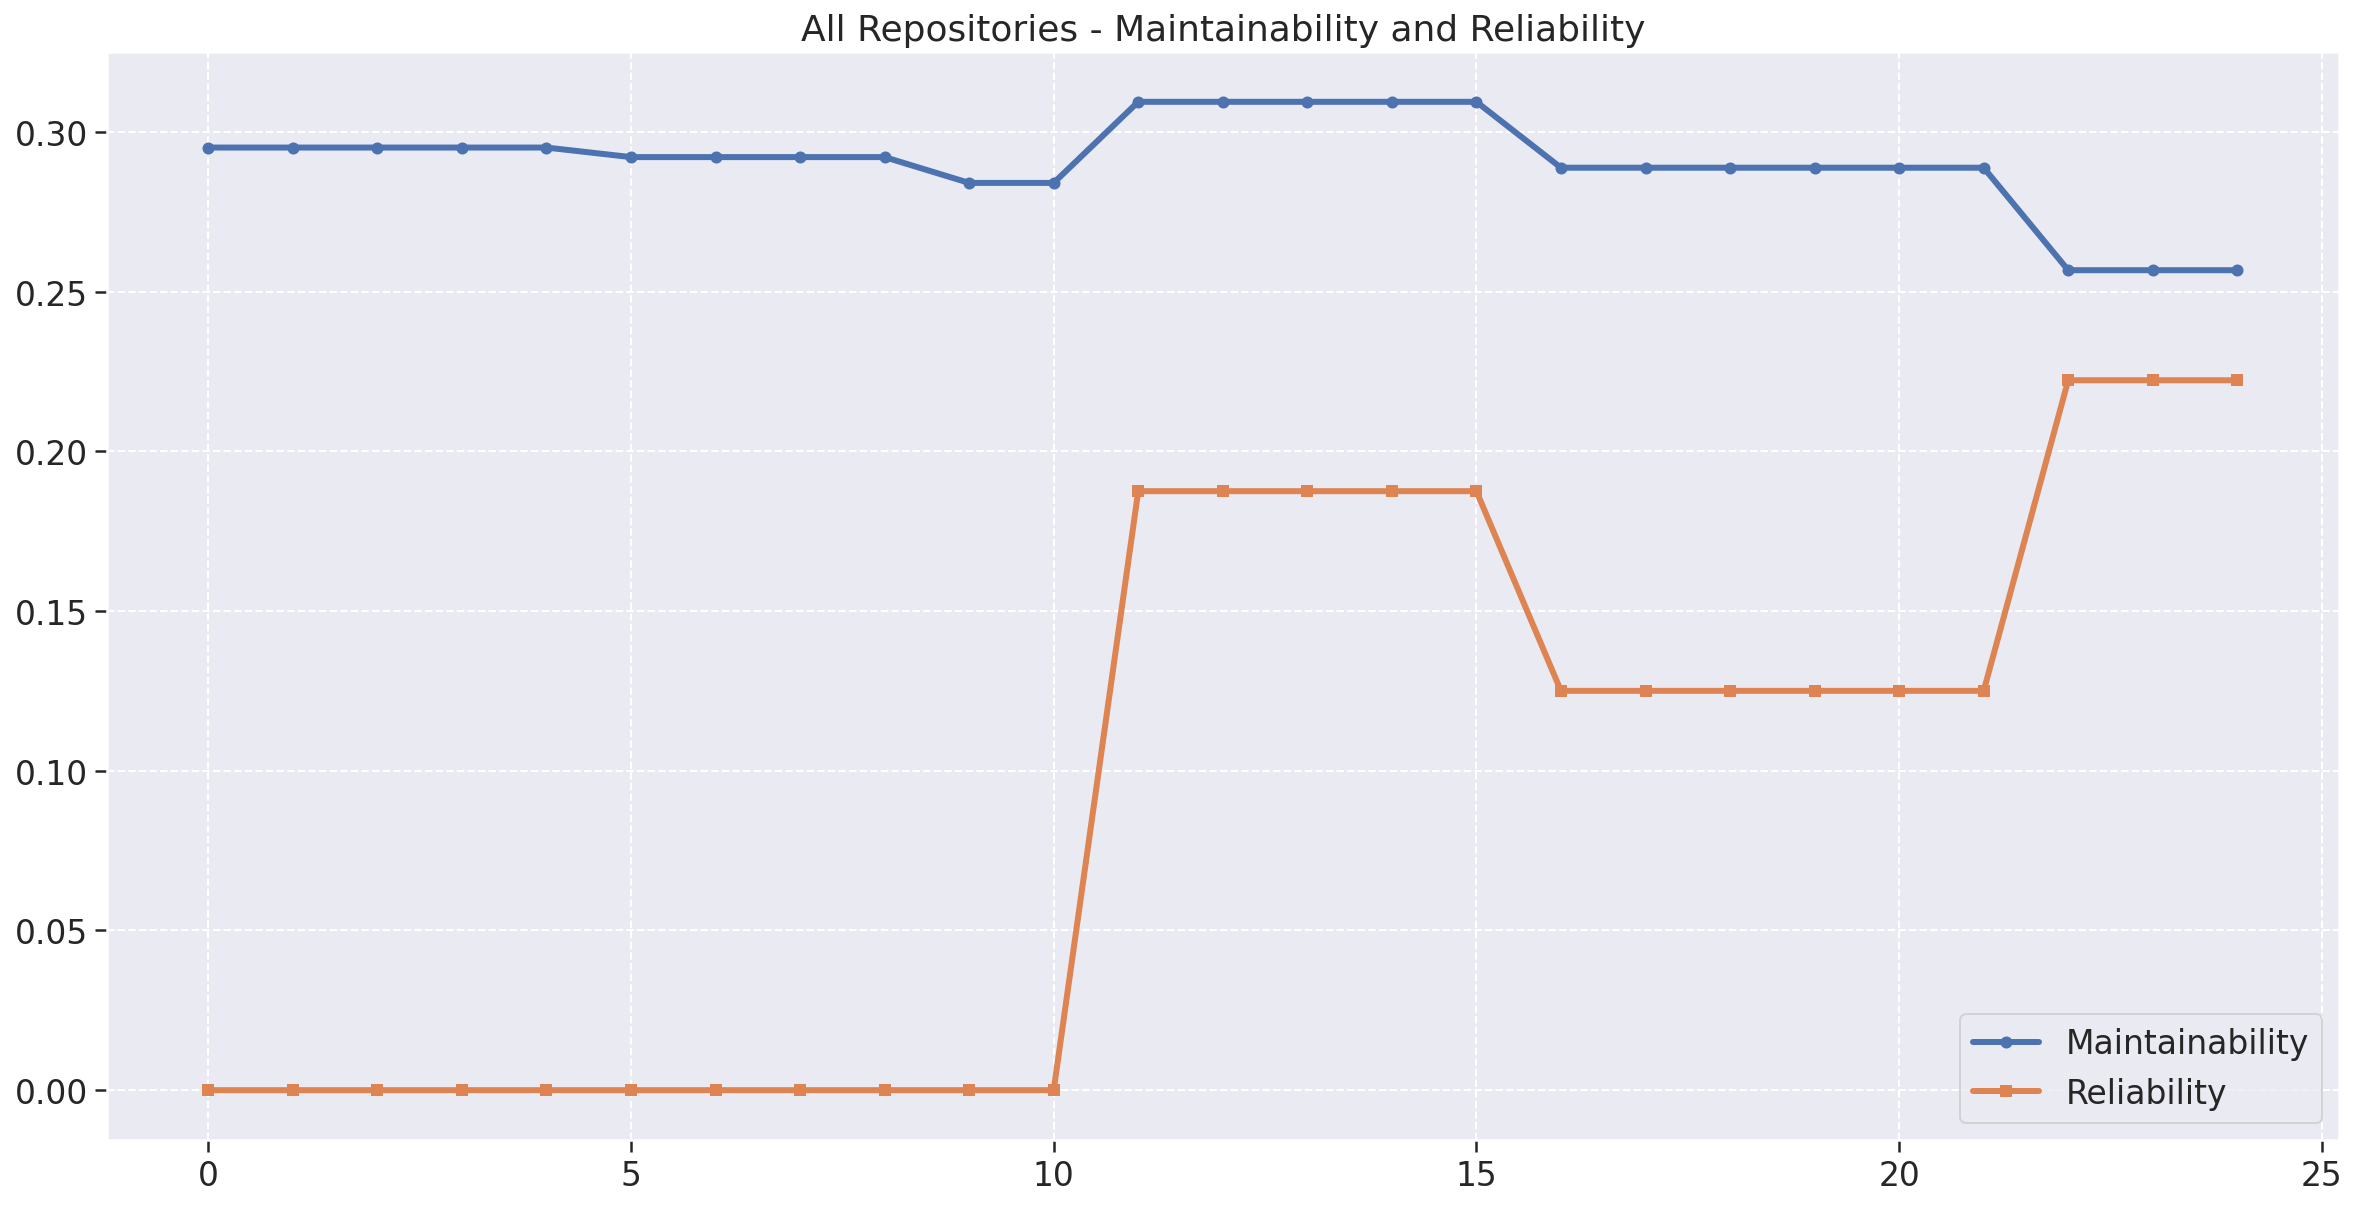

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.title('All Repositories - Maintainability and Reliability')
plt.plot(metrics_df['Maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='s', label='Reliability', markersize=5)

plt.legend()

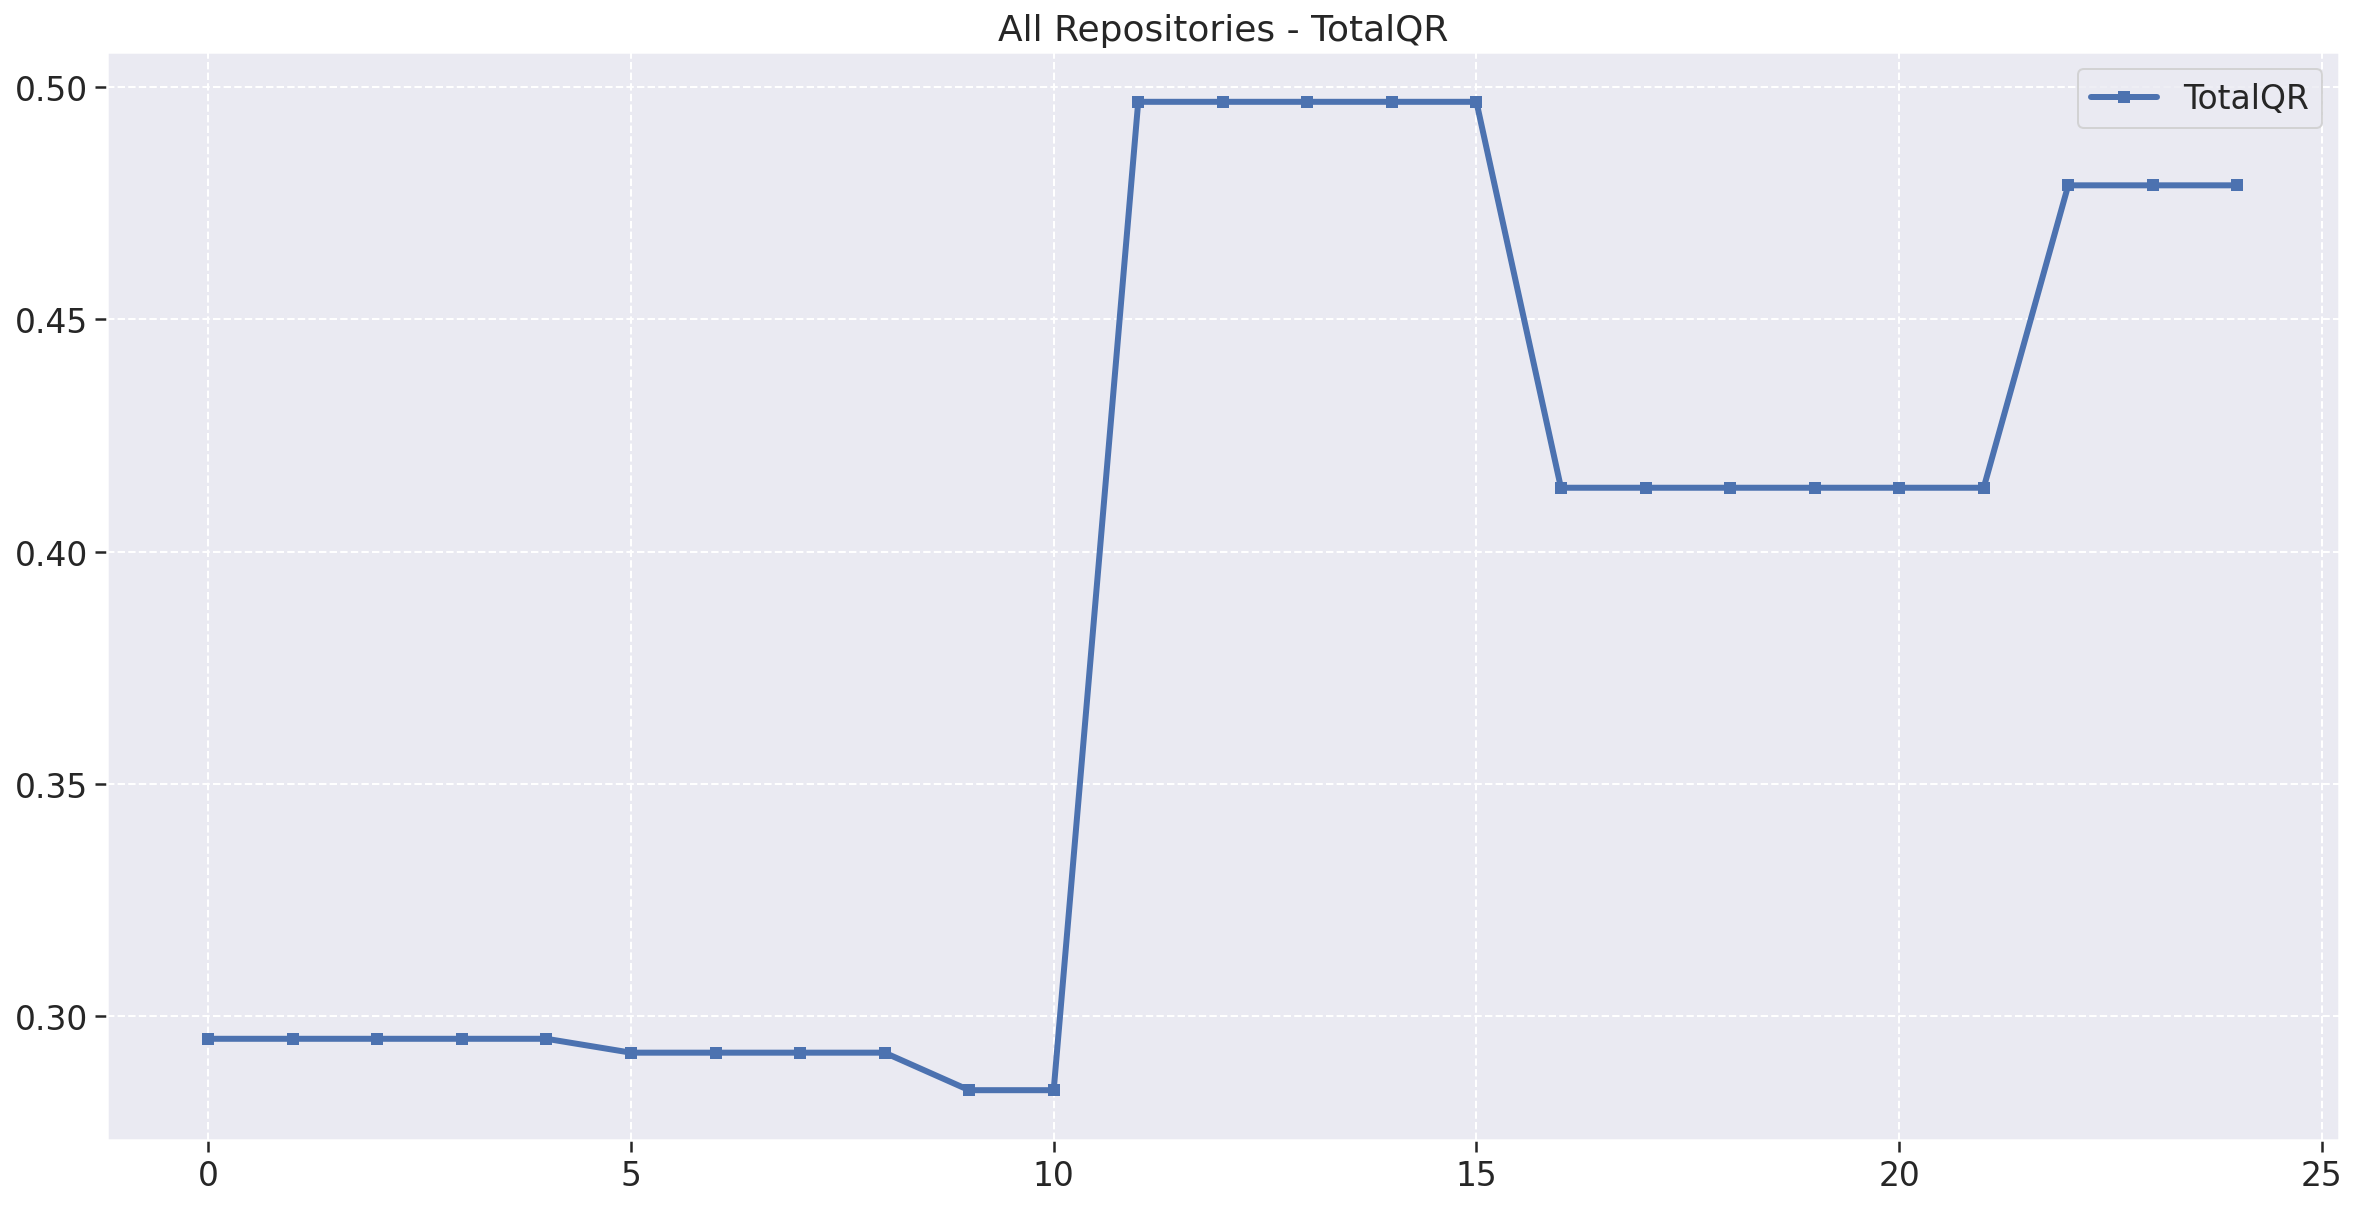

In [33]:
fig = plt.figure(figsize=(20, 10))

plt.title('All Repositories - TotalQR')
plt.plot(metrics_df['Total_QR'], linewidth=3, marker='s', label='TotalQR', markersize=5)
plt.legend()

In [34]:
del(metrics_df['code_quality'])
del(metrics_df['testing_status'])

In [35]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

# metrics_df.to_excel('data/fga-eps-mds-2021_2-Eu_Pescador-{}.xlsx'.format(currentDateTime), index = False)
metrics_df.to_csv('data/fga-eps-mds-2021_2-Eu_Pescador-{}.csv'.format(currentDateTime), index = False)

In [36]:
metrics_df = pd.concat([repo4_metrics], ignore_index=True)

metrics_df['Maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['Total_QR'] = metrics_df['Maintainability'] + metrics_df['Reliability']

In [37]:
metrics_df

,m1,m2,m3,m6,LOC,Repository,Version,Date,code_quality,testing_status,Maintainability,Reliability,Total_QR
0,0.625000,0.125000,1.000000,0.250000,384,FishLog,2.1.1,03-18-2022-15:28:02,0.577500,0.250000,0.288750,0.125000,0.413750
1,0.625000,0.125000,1.000000,0.250000,384,FishLog,2.2.0,04-12-2022-11:21:33,0.577500,0.250000,0.288750,0.125000,0.413750
2,0.625000,0.125000,1.000000,0.250000,384,FishLog,2.2.1,04-12-2022-19:58:38,0.577500,0.250000,0.288750,0.125000,0.413750
3,0.555556,0.111111,0.888889,0.444444,357,FishLog,2.2.2,04-19-2022-11:10:51,0.513333,0.444444,0.256667,0.222222,0.478889
4,0.555556,0.111111,0.888889,0.444444,357,FishLog,2.2.3,04-30-2022-00:08:53,0.513333,0.444444,0.256667,0.222222,0.478889
5,0.555556,0.111111,0.888889,0.444444,357,FishLog,2.2.4,05-04-2022-23:33:57,0.513333,0.444444,0.256667,0.222222,0.478889


## Analysis

### Descriptive Statistics (microservice with the highest number of releases)

In [44]:
analysis = pd.DataFrame(columns=['Média', 'Moda', 'Mediana', 'DesvioPadrão', 'Variância', 'Minínimo', 'Máximo'])

analysis.loc['Maintainability'] = [
  metrics_df['Maintainability'].mean(),
  list(metrics_df['Maintainability'].mode()),
  metrics_df['Maintainability'].median(),
  metrics_df['Maintainability'].std(),
  metrics_df['Maintainability'].var(),
  metrics_df['Maintainability'].min(),
  metrics_df['Maintainability'].max()
]

analysis.loc['Reliability'] = [
  metrics_df['Reliability'].mean(),
  list(metrics_df['Reliability'].mode()),
  metrics_df['Reliability'].median(),
  metrics_df['Reliability'].std(),
  metrics_df['Reliability'].var(),
  metrics_df['Reliability'].min(),
  metrics_df['Reliability'].max()
]

analysis

,Média,Moda,Mediana,DesvioPadrão,Variância,Minínimo,Máximo
Maintainability,0.272708,"[0.2566666666666667, 0.28875]",0.272708,0.017573,0.000309,0.256667,0.288750
Reliability,0.173611,"[0.125, 0.2222222222222222]",0.173611,0.053251,0.002836,0.125000,0.222222


### Box-Plot (microservice with the highest number of releases)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5f67142130>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5f67142880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5f67135e50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5f67142fa0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5f6714f370>,
 'means': []}

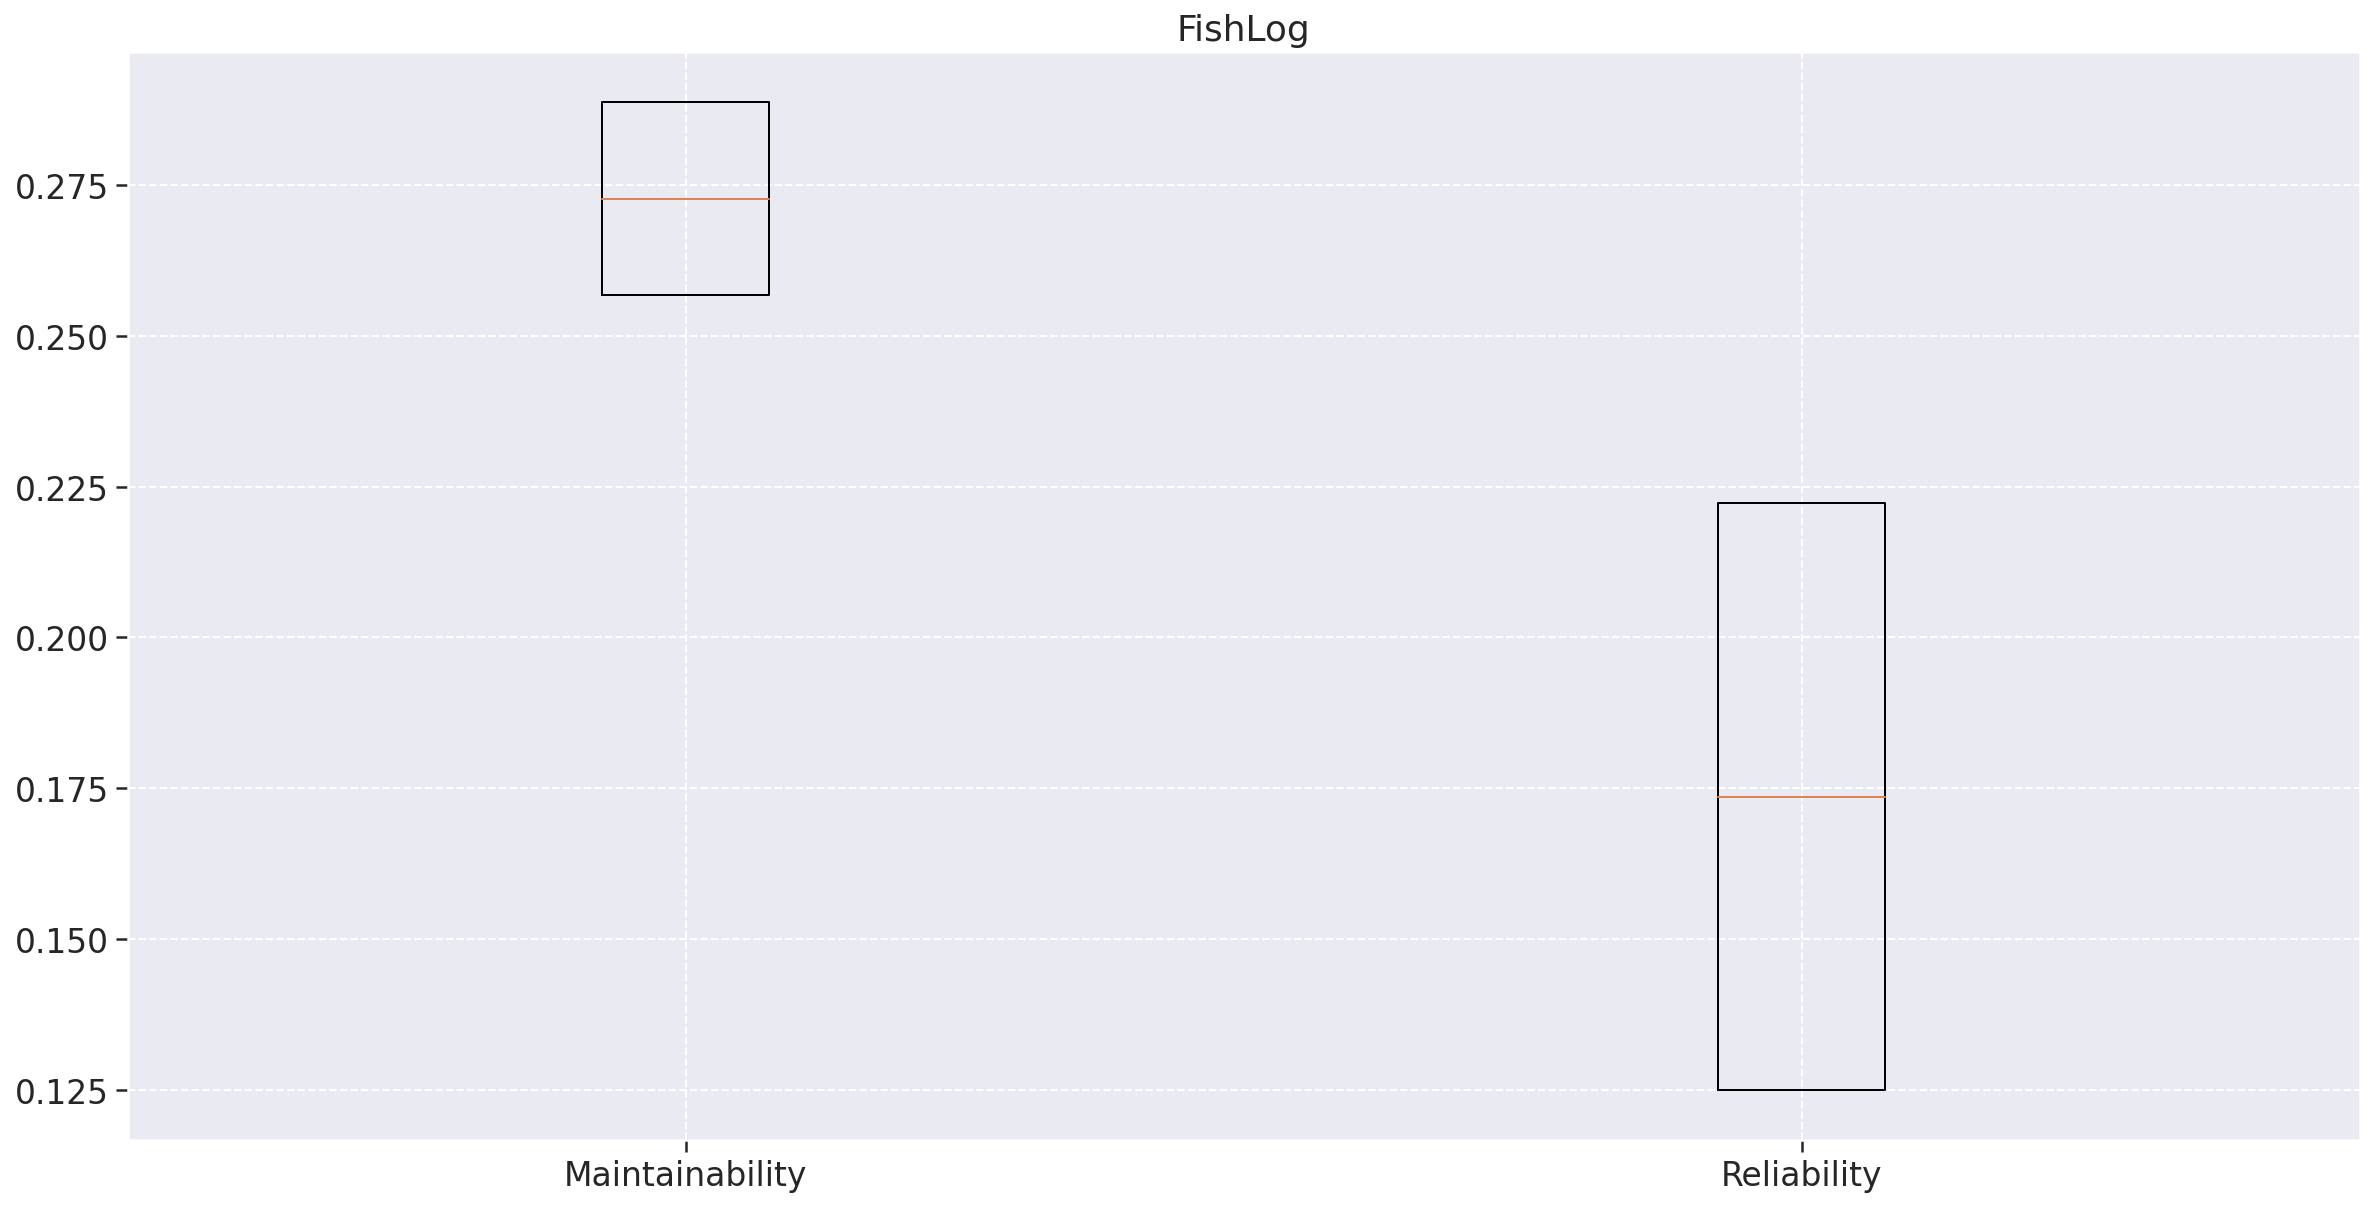

In [47]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishLog')
plt.boxplot([metrics_df['Maintainability'], metrics_df['Reliability']], labels=['Maintainability','Reliability'])

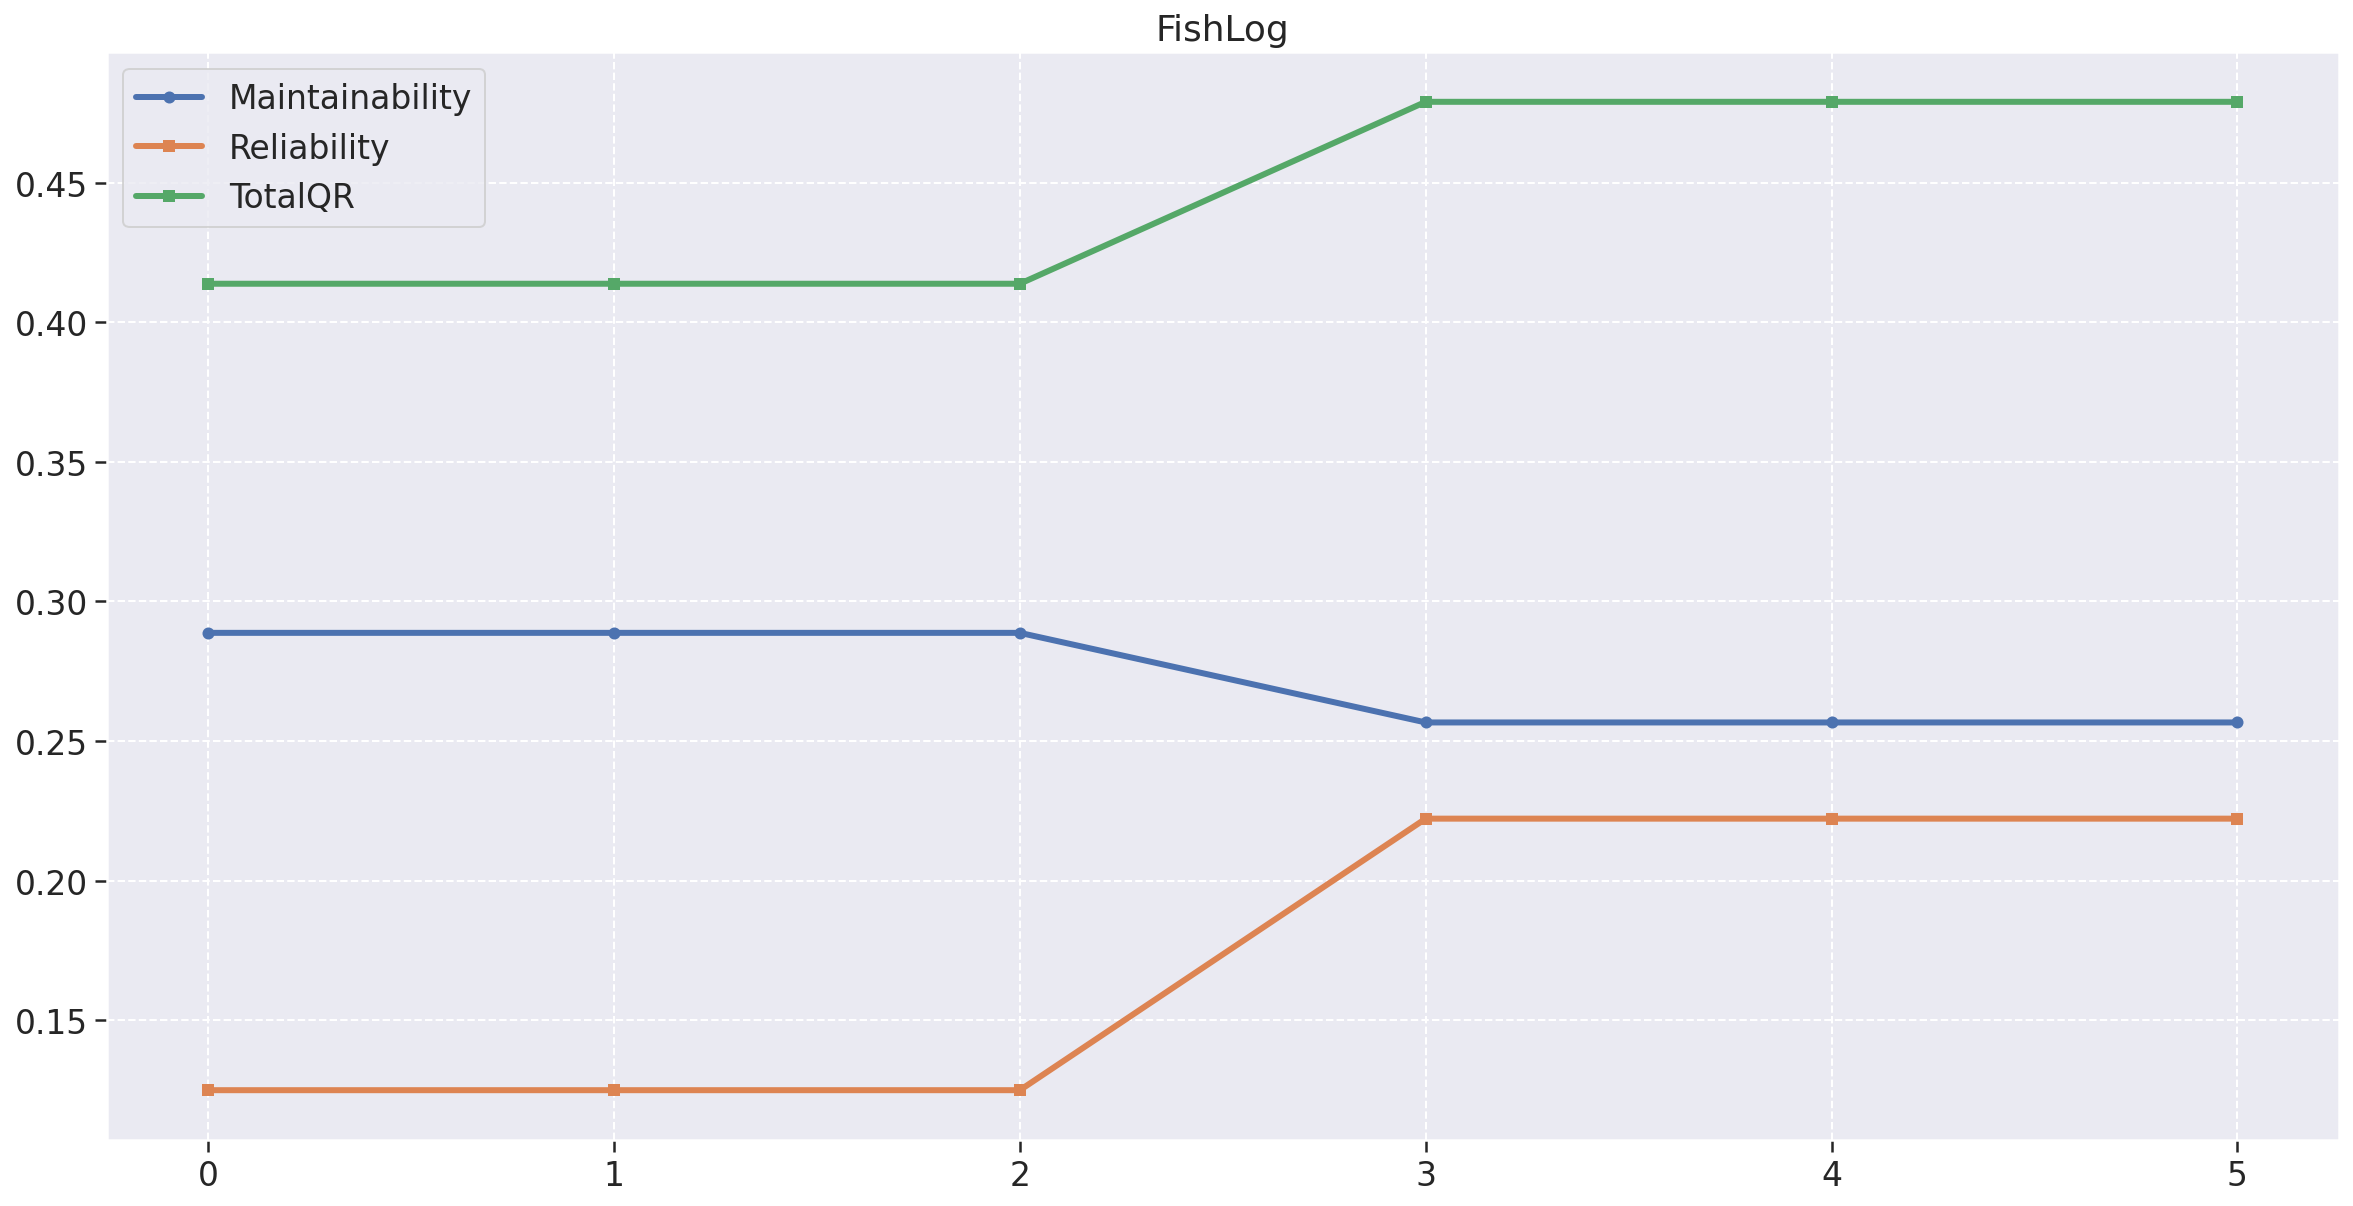

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishLog')
plt.plot(metrics_df['Maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='s', label='Reliability', markersize=5)
plt.plot(metrics_df['Total_QR'], linewidth=3, marker='s', label='TotalQR', markersize=5)
plt.legend()